# Clustering
# Data

In [2]:
import pandas as pd
articles = pd.read_csv('articles.tsv', sep='\t', names=['title', 'text'])
articles.head()

,title,text
0,-hou,-hou is a suffix (part added to the end of a w...
1,.htaccess,.htaccess is a type of computer file for the c...
2,16-cell,"In four dimensional geometry, a 16-cell, is a ..."
3,2007 Universal Forum of Cultures,The Universal Forum of Cultures Monterrey 2007...
4,20th century in literature,Literature of the 20th century refers to world...


In [3]:
# preprocess using tf idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
text_data = vectorizer.fit_transform(articles['text'])

# How many clusters?
Since this are just random wikipedia articles, I can't manually estimate the number of clusters, so let's use an algorithm for this.
We've seen following during the lecture: After the optimal number of clusters is reached, the SSE will
still decrease, but the decrease will be less outspoken.
## Using K-Means

In [3]:
import numpy as np

def calculate_sse(cluster_centers, X):
    # Based on code from here: https://towardsdatascience.com/bisecting-k-means-algorithm-clustering-in-machine-learning-1bd32be71c1c
    cluster_centers = kmeans.cluster_centers_
    sse = 0
    for point, label in zip(X, kmeans.labels_):
        sse += np.square(point-cluster_centers[label]).sum()
    return sse

In [6]:
# Perform K-means for different numbers of clusters and plot the SSE
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

MIN_CLUSTERS = 2
MAX_CLUSTERS = 50
#amount_of_clusters_to_try = MAX_CLUSTERS - MIN_CLUSTERS + 1
sse_list = [] # List of tuples containing (number of clusters, SSE)


for k in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(text_data)

    # Evaluate the clustering performance
    sse = calculate_sse(kmeans.cluster_centers_, text_data)
    sse_list.append((k, sse))

    print(f"For k = {k}, the SSE is {sse}")

For k = 2, the SSE is 2073.077401112965
For k = 3, the SSE is 2064.049319680482
For k = 4, the SSE is 2056.1938371764527
For k = 5, the SSE is 2050.4017907728617
For k = 6, the SSE is 2042.195679623588
For k = 7, the SSE is 2034.8565961313768
For k = 8, the SSE is 2029.043015237322
For k = 9, the SSE is 2023.3987748624936
For k = 10, the SSE is 2019.8676094757943
For k = 11, the SSE is 2014.7568266108976
For k = 12, the SSE is 2013.3673480836128
For k = 13, the SSE is 2007.614577914361
For k = 14, the SSE is 2002.9159370684556
For k = 15, the SSE is 2002.168350191205
For k = 16, the SSE is 1996.5717506433825
For k = 17, the SSE is 1992.0890692344644
For k = 18, the SSE is 1992.0943515453814
For k = 19, the SSE is 1987.8920911067546
For k = 20, the SSE is 1985.7276620177222
For k = 21, the SSE is 1982.2883305697064
For k = 22, the SSE is 1979.5130748832873
For k = 23, the SSE is 1977.6236533569358
For k = 24, the SSE is 1975.841494850644
For k = 25, the SSE is 1973.1741860206337
For k =

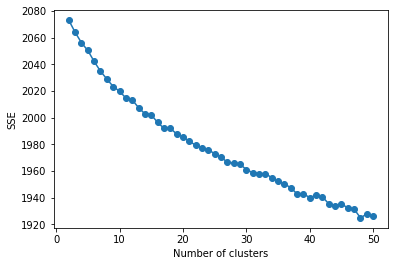

In [8]:
# plot the SSE
plt.plot([x[0] for x in sse_list], [x[1] for x in sse_list], '-o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.savefig('cluster_count_sse.png')

As you can see in the graph, the SSE keeps decreasing, but still hasn't reached a point where the decrease is significantly less outspoken (like the graph in the lecture). Because we already have some difference between sse's of less than 1, I don't think this point will still come, so I'll try another method to find the number of clusters.
You can argue that there is a small change at the 9th element, but its so small, it's probably not the number we're searching for (unless we can't find a better number).
## Using DBScan

100%|██████████| 14/14 [01:34<00:00,  6.77s/it]


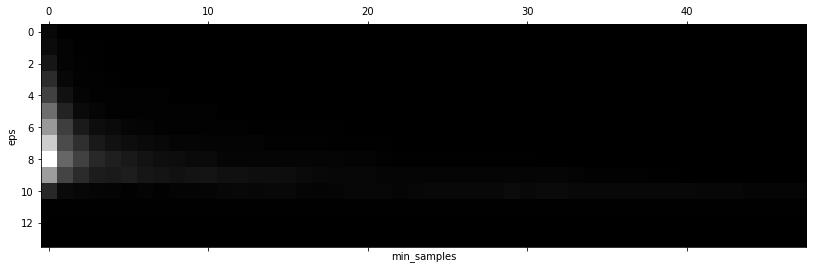

In [62]:
from sklearn.cluster import DBSCAN
import numpy as np
from tqdm import tqdm

eps_range = np.arange(0.8, 1.5, 0.05)
min_samples_range = np.arange(2, 50, 1)
m = np.zeros((len(eps_range), len(min_samples_range)))

for eps_idx, eps in enumerate(tqdm(eps_range)):
    for min_samples_idx, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(text_data)
        no_clusters = len(set(dbscan.labels_))
        m[eps_idx][min_samples_idx] = no_clusters

plt.matshow(m, cmap=plt.get_cmap('gray'))
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.show()

Note that the indices along the axis are still wrong. The y-axis should range from 0.8 to 1.5, and the x-axis should range from 2 to 12. We get the most clusters with eps 1.2 and of course the lower the minimum samples, the higher the number of clusters.

100%|██████████| 48/48 [00:05<00:00,  8.07it/s]


Text(0, 0.5, 'Number of clusters')

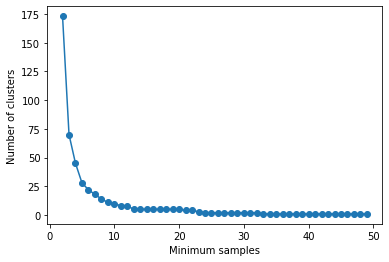

100%|██████████| 48/48 [00:05<00:00,  8.16it/s]


Text(0, 0.5, 'Number of clusters')

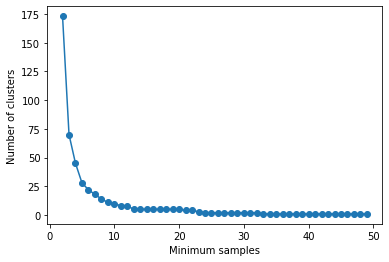

In [51]:
# Keep eps fixed now and create a plot of the number of clusters for different min_samples
min_samples_range = np.arange(2, 50, 1)
min_samples_list = []
no_clusters_list = []
for min_sample in tqdm(min_samples_range):
    dbscan = DBSCAN(eps=1.2, min_samples=min_sample).fit(text_data)
    no_clusters = len(set(dbscan.labels_))

    min_samples_list.append(min_sample)
    no_clusters_list.append(no_clusters)

plt.plot(min_samples_list, no_clusters_list, '-o')
plt.xlabel('Minimum samples')
plt.ylabel('Number of clusters')

The number of clusters is heading quite fast to one large cluster, so also not really useful to determine the number of clusters.

In [60]:
dbscan = DBSCAN(eps=1.2, min_samples=10).fit(text_data)
no_clusters = len(set(dbscan.labels_))
print(f"An estimated number of clusters is {no_clusters}")

An estimated number of clusters is 10


In [69]:
eps_range = np.arange(1.1, 1.5, 0.005)
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=40).fit(text_data)
    no_clusters = len(set(dbscan.labels_))
    print(f"For eps = {eps}, the number of clusters is {no_clusters}")

For eps = 1.1, the number of clusters is 1
For eps = 1.105, the number of clusters is 1
For eps = 1.1099999999999999, the number of clusters is 1
For eps = 1.1149999999999998, the number of clusters is 1
For eps = 1.1199999999999997, the number of clusters is 1
For eps = 1.1249999999999996, the number of clusters is 1
For eps = 1.1299999999999994, the number of clusters is 1
For eps = 1.1349999999999993, the number of clusters is 1
For eps = 1.1399999999999992, the number of clusters is 1
For eps = 1.1449999999999991, the number of clusters is 1
For eps = 1.149999999999999, the number of clusters is 1
For eps = 1.154999999999999, the number of clusters is 1
For eps = 1.1599999999999988, the number of clusters is 1
For eps = 1.1649999999999987, the number of clusters is 1
For eps = 1.1699999999999986, the number of clusters is 1
For eps = 1.1749999999999985, the number of clusters is 1
For eps = 1.1799999999999984, the number of clusters is 1
For eps = 1.1849999999999983, the number of 

The most number of clusters is for eps = 1.305, so I'll use that. Let's now take a look at how the elements are distributed along the cluster.

In [74]:
dbscan = DBSCAN(eps=1.305, min_samples=40).fit(text_data)
unique_elements, counts_elements = np.unique(dbscan.labels_, return_counts=True)
for unique_element, count_element in zip(unique_elements, counts_elements):
    print(f"For cluster {unique_element}, there are {count_element} elements")

For cluster -1, there are 1631 elements
For cluster 0, there are 124 elements
For cluster 1, there are 100 elements
For cluster 2, there are 102 elements
For cluster 3, there are 59 elements
For cluster 4, there are 44 elements
For cluster 5, there are 40 elements


Almost everything is in one cluster, so this is also not a great solution.
## Conclusion
There isn't a clear number of clusters, but 9 gave some slight changes in both of our test methods, so let's try to make some clusters based on this.

# K-means
K-means has problems when clusters are of different size, density or have non-globular shapes.
K-means also has problems when the data contains outliers (use median instead of mean).
## K-means

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(text_data)

## Bisecting K-meanst
This code is copied from [here]().

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

K = 5
current_clusters = 1
X = text_data
while current_clusters != K:
    kmeans = KMeans(n_clusters=2).fit(text_data)
    current_clusters += 1
    cluster_centers = kmeans.cluster_centers_
    sse = [0]*2
    for point, label in zip(X, kmeans.labels_):
        sse[label] += np.square(point-cluster_centers[label]).sum()
    chosen_cluster = np.argmax(sse, axis=0)
    chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]
    X = chosen_cluster_data

# Write to file

In [ ]:
model = dbscan

titles = articles.title.values
labels = model.fit_predict(text_data)

assert len(titles) == len(labels)

file = open("clusters.tsv", "w+")
for title, label in zip(titles, labels):
    file.write(f"{title}\t{label}\n")
file.close()